In [14]:
import matplotlib.pyplot as plt
import pandas as pd

#데이터 불러오기
traveler_master = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_traveller_master_여행객 Master_A.csv")
trv_info = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_travel_여행_A.csv")
visit = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_visit_area_info_방문지정보_A.csv")
post_data = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_adv_consume_his_사전소비내역_A.csv")
lod_data = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_lodge_consume_his_숙박소비내역_A.csv")
acti_data = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_activity_consume_his_활동소비내역_A.csv")
traf_data = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_mvmn_consume_his_이동수단소비내역_A.csv")
comp = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_companion_info_동반자정보_A.csv")

In [15]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import joblib
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

소비내역과 만족도의 연관성 분석

방문지 정보 전처리

In [16]:
visit.dropna(subset = ['LOTNO_ADDR'], inplace = True)
visit = visit.reset_index(drop = True)

# 시도/군구 변수 생성
sido = []
gungu = []
for i in range(len(visit['LOTNO_ADDR'])):
    sido.append(visit['LOTNO_ADDR'][i].split(' ')[0])
    gungu.append(visit['LOTNO_ADDR'][i].split(' ')[1])
    

visit['SIDO'] = sido
visit['SIDO'] = visit['SIDO'].replace({'경기도': '경기'})
visit['SIDO'] = visit['SIDO'].replace({'강원도': '강원'})
visit['SIDO'] = visit['SIDO'].replace({'경상북도': '경북'})
visit['SIDO'] = visit['SIDO'].replace({'인천광역시': '인천'})
visit['SIDO'] = visit['SIDO'].replace({'서울특별시': '서울'})
visit['GUNGU'] = gungu

visit = visit[['TRAVEL_ID', 'VISIT_AREA_NM', 'SIDO', 'GUNGU', 'VISIT_AREA_TYPE_CD', 'DGSTFN',
                                  'REVISIT_INTENTION', 'RCMDTN_INTENTION', 'RESIDENCE_TIME_MIN', 'REVISIT_YN']]
trv_info = trv_info[['TRAVEL_ID', 'TRAVELER_ID' ]]

# master 전처리
traveler_master = traveler_master[['TRAVELER_ID', 'GENDER', 'AGE_GRP', 'INCOME', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM' ]]

# 합치기
df = pd.merge(trv_info, traveler_master, left_on = 'TRAVELER_ID', right_on = 'TRAVELER_ID', how = 'inner')
df = pd.merge(visit, df, left_on = 'TRAVEL_ID', right_on = 'TRAVEL_ID', how = 'right')

#결측치 제거
df = df.dropna(subset = ['DGSTFN'])
df.reset_index(drop=True, inplace=True)

#재방문 더미화
df['REVISIT_YN'] = df['REVISIT_YN'].replace("N",0)
df['REVISIT_YN'] = df['REVISIT_YN'].replace("Y",1)

In [ ]:
# 소비 데이터 전처리

In [17]:
lod_data = lod_data[["PAYMENT_NUM","PAYMENT_AMT_WON","PAYMENT_MTHD_SE","TRAVEL_ID","RSVT_YN"]]

#재방문 더미화
lod_data['RSVT_YN'] = lod_data['RSVT_YN'].replace("N",0)
lod_data['RSVT_YN'] = lod_data['RSVT_YN'].replace("Y",1)

df_lod = pd.merge(lod_data, df, left_on = 'TRAVEL_ID', right_on = 'TRAVEL_ID', how = 'right')

#결측치 제거
df_lod = df_lod.dropna(subset = ['PAYMENT_NUM'])
df_lod.reset_index(drop=True, inplace=True)

cor= df_lod.corr(numeric_only= True)


In [25]:
traveler_master

TRAVELER_ID GENDER  AGE_GRP  INCOME  TRAVEL_NUM  TRAVEL_COMPANIONS_NUM
0        b015583      여       20       3           2                      1
1        a001105      남       30       4           1                      7
2        a001673      여       30       5           3                      2
3        a017690      여       30       5           6                      3
4        c006666      여       30       3           1                      0
...          ...    ...      ...     ...         ...                    ...
3195     b006351      여       30       4          10                      0
3196     a000318      남       20       5           2                     19
3197     a000787      남       30       5           5                      1
3198     b011659      여       40      11           1                      2
3199     a008435      남       20       5           2                      0

[3200 rows x 6 columns]

In [26]:
#여행데이터 다시 가져오기
trv_info = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_travel_여행_A.csv")
traveler_master = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_traveller_master_여행객 Master_A.csv")

consume_data_list=[post_data,lod_data,traf_data,acti_data]
traveler_data=traveler_master
  #소비내역데이터에 traveler_id 추가
for d in consume_data_list:
  d['TRAVELER_ID']=np.nan
  for i in range(len(d)):
    d['TRAVELER_ID'][i]=d['TRAVEL_ID'][i].split("_",1)[1]
# 소비 금액 총합 내역 제작
  #여행자id와 소비금액을 모든 소비내역에 대해 합친 하나의 데이터 프레임 생성
payment_data= pd.DataFrame()
payment_data['TRAVELER_ID']=np.nan
payment_data['PAYMENT_AMT_WON']=np.nan
for d in consume_data_list:
  add_df=d[['TRAVELER_ID','PAYMENT_AMT_WON']]
  payment_data= pd.concat([payment_data, add_df])
#여행자id-총소비액 데이터프레임 구축
payment_sum_data=pd.DataFrame()
payment_sum_data=payment_data.groupby('TRAVELER_ID').sum()
#index 정렬
payment_sum_data=payment_sum_data.reset_index()

      
  # 여행 출발 전 미리 숙소를 예약한 사람들의 숙소 금액 추출
use_lod=lod_data[lod_data['RSVT_YN']=='Y']
use_lod=use_lod[['TRAVELER_ID','PAYMENT_AMT_WON']]
use_lod=use_lod.groupby('TRAVELER_ID').aggregate({'PAYMENT_AMT_WON':sum})
use_lod['pre_PAYMENT_load']=use_lod['PAYMENT_AMT_WON']
use_lod=use_lod.drop(['PAYMENT_AMT_WON'],axis=1)

  # 숙박 예약 내역 10개 bin으로 나누기
use_lod_cat=use_lod
use_lod_cat['pre_PAYMENT_load_rank'] = use_lod_cat.pre_PAYMENT_load.rank(pct = True)
use_lod_cat['pre_PAYMENT_load']=round(use_lod_cat['pre_PAYMENT_load_rank'],1)
use_lod_cat=use_lod_cat.drop('pre_PAYMENT_load_rank',axis=1)
use_lod_cat

  # 여행 페르소나 추출
persona=trv_info[["TRAVELER_ID","TRAVEL_PERSONA"]]
  # 주요 이동수단 추출
main_vehicle=trv_info[["TRAVELER_ID","MVMN_NM"]]

  #돈쓴 내역이 있는 traveler만 사용
traveler_data = pd.merge(traveler_data, payment_sum_data['TRAVELER_ID'], left_on='TRAVELER_ID', right_on='TRAVELER_ID', how='inner')

  # 상위 20% 기준으로 '고지출' 분류, 타겟 Variable 제작
  #총소비액 기준 상위 20%는 1, 나머지는 0을 부여하는 binary col 추가해주는 과정
payment_sum_data['payment_bin']=np.nan
num_upper_20=int(0.2*len(payment_sum_data))
payment_sum_data=payment_sum_data.sort_values(by='PAYMENT_AMT_WON', ascending=False)
payment_sum_data['payment_bin'][:num_upper_20]=1
payment_sum_data['payment_bin'][num_upper_20:]=0

# 하위 20%
payment_sum_data['payment_bin1']=np.nan
num_under_80=int(0.8*len(payment_sum_data))
payment_sum_data['payment_bin1'][num_under_80:]=1
payment_sum_data['payment_bin1'][:num_under_80]=0
payment_sum_data=payment_sum_data.reset_index()

thr_1=payment_sum_data['PAYMENT_AMT_WON'][num_upper_20-1]
thr_2=payment_sum_data['PAYMENT_AMT_WON'][num_upper_20]
avg_spend=payment_sum_data['PAYMENT_AMT_WON'].mean()
num_ppl=len(payment_sum_data)

  # 데이터 불균형 확인
np.unique( payment_sum_data['payment_bin'], return_counts= True )

  #test, train 순서 맞춰주기 위한 정렬 작업
payment_sum_data=payment_sum_data.sort_values(by='TRAVELER_ID').reset_index(drop=True)
payment_sum_data=pd.merge(traveler_data['TRAVELER_ID'], payment_sum_data, left_on='TRAVELER_ID', right_on='TRAVELER_ID', how='inner')
payment_sum_data=payment_sum_data.drop(['index'],axis=1)

  # 날짜 데이터 처리
  # 여행 시작 및 종료 날짜 정보 추출
import datetime
traveler_data['start_day'] = traveler_data.TRAVEL_STATUS_YMD.str.split('~').str[0]
traveler_data['end_day'] = traveler_data.TRAVEL_STATUS_YMD.str.split('~').str[1]
traveler_data['start_day'] = pd.to_datetime(traveler_data['start_day'])
traveler_data['end_day'] = pd.to_datetime(traveler_data['end_day'])
trip_day_raw=traveler_data['end_day']-traveler_data['start_day']

  # 여행 일수 feature 추가
traveler_data['trip_day']=trip_day_raw.dt.days + 1

  # 제작과정 feature drop
traveler_data=traveler_data.drop(["TRAVEL_STATUS_YMD","start_day","end_day"],axis=1)

  #동반자 데이터 처리
companicon_data = comp
companicon_data['COMPANION_AGE_avg']=10*(companicon_data['COMPANION_AGE_GRP']-1)+5

companicon_data['TRAVELER_ID']=np.nan
for i in range(len(companicon_data)):
  companicon_data['TRAVELER_ID'][i]=companicon_data['TRAVEL_ID'][i].split("_",1)[1]

companicon_data['COMPANION_AGE_avg'] = companicon_data['COMPANION_AGE_avg'].apply(lambda x: [x])
comp_age=companicon_data.groupby('TRAVELER_ID').agg({'COMPANION_AGE_avg': 'sum'})

  #동반자 연령 평균
s=0
l=0
for i in comp_age['COMPANION_AGE_avg']:
  l+=len(i)
  for j in i:
    s+=j
avg=s/l

from statistics import mean
comp_age['age_avg']=np.nan
for i in range(len(comp_age)):
  if len(comp_age['COMPANION_AGE_avg'][i])>0:
    comp_age['age_avg'][i]=mean(comp_age['COMPANION_AGE_avg'][i])
  else:
    comp_age['age_avg'][i]=np.nan

comp_age=comp_age.drop('COMPANION_AGE_avg',axis=1)

  #final data제작

  ## traveler_data에 필요 데이터 추가
  ## 추출한 여행자 정보 하나로 통합
traveler_data=pd.merge(traveler_data, use_lod_cat, on='TRAVELER_ID', how='left')
traveler_data=pd.merge(traveler_data, persona, on='TRAVELER_ID', how='left')
traveler_data=pd.merge(traveler_data, main_vehicle, on='TRAVELER_ID', how='left')
traveler_data= pd.merge(traveler_data, comp_age, left_on='TRAVELER_ID', right_on='TRAVELER_ID', how='left')
traveler_data=traveler_data.drop(["TRAVEL_LIKE_SGG_1","TRAVEL_LIKE_SGG_2","TRAVEL_LIKE_SGG_3"], axis=1 )

  ## x,y 통합한 final data 제작
final_data=pd.merge(traveler_data, payment_sum_data[['TRAVELER_ID','payment_bin','payment_bin1','PAYMENT_AMT_WON']], on='TRAVELER_ID', how='inner')
final_data=final_data.dropna(axis=0,subset=['EDU_FNSH_SE','MARR_STTS'])

C:\Users\yongseok2\AppData\Local\Temp\ipykernel_26672\203540502.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['TRAVELER_ID'][i]=d['TRAVEL_ID'][i].split("_",1)[1]
C:\Users\yongseok2\AppData\Local\Temp\ipykernel_26672\203540502.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'a007376' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  d['TRAVELER_ID'][i]=d['TRAVEL_ID'][i].split("_",1)[1]
C:\Users\yongseok2\AppData\Local\Temp\ipykernel_26672\203540502.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [27]:
for i in range(len(df)):
  df['TRAVELER_ID'][i]=df['TRAVEL_ID'][i].split("_",1)[1]

C:\Users\yongseok2\AppData\Local\Temp\ipykernel_26672\4085597618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TRAVELER_ID'][i]=df['TRAVEL_ID'][i].split("_",1)[1]
C:\Users\yongseok2\AppData\Local\Temp\ipykernel_26672\4085597618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TRAVELER_ID'][i]=df['TRAVEL_ID'][i].split("_",1)[1]
C:\Users\yongseok2\AppData\Local\Temp\ipykernel_26672\4085597618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [28]:
final_data1 = pd.merge(final_data, df, left_on = 'TRAVELER_ID', right_on = 'TRAVELER_ID', how = 'inner')
#재방문 더미화
final_data1['GENDER_y'] = final_data1['GENDER_y'].replace("여",0)
final_data1['GENDER_y'] = final_data1['GENDER_y'].replace("남",1)

In [29]:
# data내보내기
final_data1.to_csv('pay_data.csv', index=False, encoding='utf-8-sig')

시각화

In [ ]:
sns.barplot(x="DGSTFN", y="AGE_GRP_x", data=final_data1)
matplotlib.rc('font', family='NanumGothic')


plt.ylabel('총 지출')
plt.xlabel('만족도')
plt.title('총 지출별 만족도')



In [ ]:
plt.figure(figsize=(25, 6))
sns.barplot(x="SIDO", y="AGE_GRP_x", data=final_data1)

plt.ylabel('시도')
plt.xlabel('만족도')
plt.title('시도별 만족도')



In [113]:
final_data1['SIDO'] = final_data1['SIDO'].replace({'서울특별시': '서울'})

In [30]:
final_data1

TRAVELER_ID  RESIDENCE_SGG_CD GENDER_x  AGE_GRP_x  EDU_NM  EDU_FNSH_SE  \
0         b015583                41        여         20       6          1.0   
1         b015583                41        여         20       6          1.0   
2         b015583                41        여         20       6          1.0   
3         a001105                30        남         30       6          1.0   
4         a001105                30        남         30       6          1.0   
...           ...               ...      ...        ...     ...          ...   
13468     b011659                41        여         40       7          1.0   
13469     b011659                41        여         40       7          1.0   
13470     a008435                11        남         20       6          1.0   
13471     a008435                11        남         20       6          1.0   
13472     a008435                11        남         20       6          1.0   

       MARR_STTS  FAMILY_MEMB  JOB_NM  JOB_ETC  ...  DGSTFN  \
0            1.0            5     3.0      NaN  ...     5.0   
1            1.0            5     3.0      NaN  ...     4.0   
2            1.0            5     3.0      NaN  ...     4.0   
3            1.0            2     3.0      NaN  ...     4.0   
4            1.0            2     3.0      NaN  ...     4.0   
...          ...          ...     ...      ...  ...     ...   
13468        2.0            3     1.0      NaN  ...     5.0   
13469        2.0            3     1.0      NaN  ...     4.0   
13470        1.0            1     7.0      NaN  ...     5.0   
13471        1.0            1     7.0      NaN  ...     5.0   
13472        1.0            1     7.0      NaN  ...     5.0   

       REVISIT_INTENTION  RCMDTN_INTENTION  RESIDENCE_TIME_MIN  REVISIT_YN  \
0                    5.0               5.0                60.0           0   
1                    3.0               3.0                30.0           0   
2                    3.0               5.0               120.0           0   
3                    4.0               4.0                30.0           0   
4                    3.0               4.0               270.0           1   
...                  ...               ...                 ...         ...   
13468                5.0               5.0                30.0           0   
13469                3.0               4.0                30.0           1   
13470                5.0               5.0                30.0           1   
13471                5.0               5.0                60.0           1   
13472                5.0               5.0                30.0           1   

       GENDER_y  AGE_GRP_y  INCOME_y  TRAVEL_NUM_y  TRAVEL_COMPANIONS_NUM_y  
0             0         20         3             2                        1  
1             0         20         3             2                        1  
2             0         20         3             2                        1  
3             1         30         4             1                        7  
4             1         30         4             1                        7  
...         ...        ...       ...           ...                      ...  
13468         0         40        11             1                        2  
13469         0         40        11             1                        2  
13470         1         20         5             2                        0  
13471         1         20         5             2                        0  
13472         1         20         5             2                        0  

[13473 rows x 55 columns]

Text(0.5, 1.0, '연령층별 체류시간(분)')

D:\anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  func(*args, **kwargs)
D:\anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  func(*args, **kwargs)
D:\anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
D:\anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  func(*args, **kwargs)
D:\anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  func(*args, **kwargs)
D:\anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from current font.
  func(*args, **kwargs)
D:\anaconda\Lib\site-packages\IPython\core\even

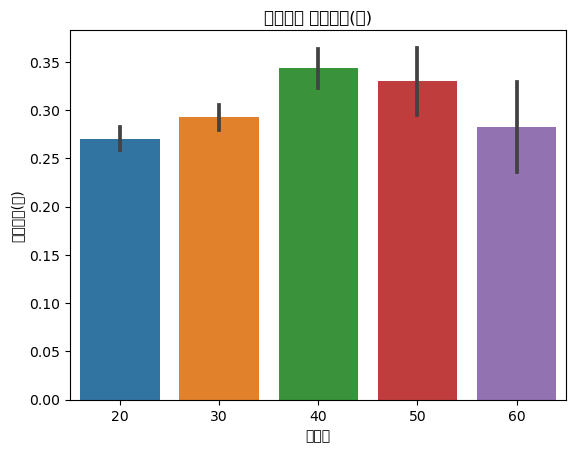

In [33]:
#plt.figure(figsize=(25, 6))
import matplotlib.pyplot as plt


sns.barplot(x="AGE_GRP_x", y="REVISIT_YN", data=final_data1)



#plt.ylim(3,5)
plt.ylabel('체류시간(분)')
plt.xlabel('연령층')
plt.title('연령층별 체류시간(분)')



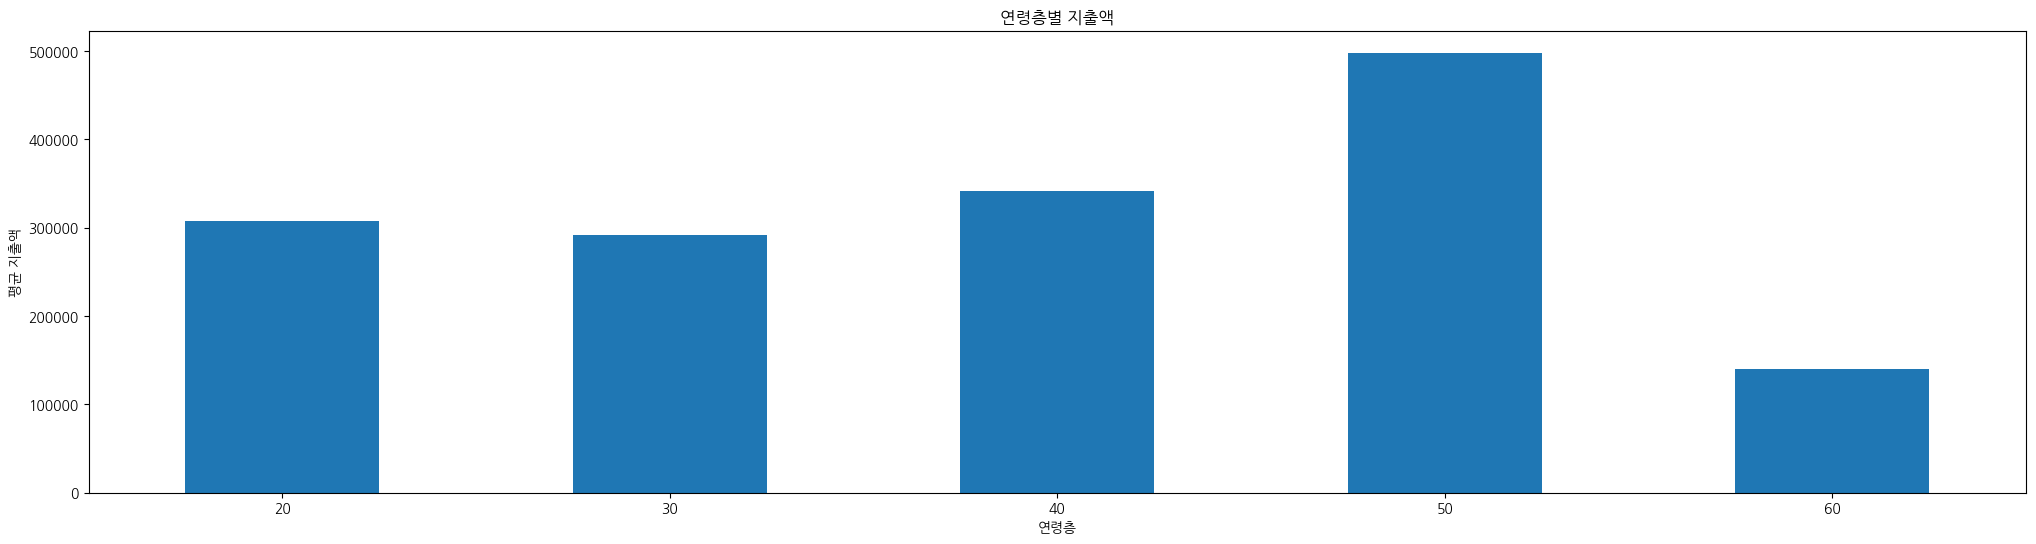

In [131]:
# '나이대'와 '방문지역' 별로 그룹핑하고 각 그룹의 크기(빈도) 계산
visit_counts = final_data1.groupby("AGE_GRP_x")["PAYMENT_AMT_WON"].mean()



# 시각화
plt.figure(figsize=(25, 6))
visit_counts.plot(kind='bar', x="AGE_GRP_x", y="PAYMENT_AMT_WON")
#plt.ylim(20,35)
plt.title('연령층별 지출액')
plt.xlabel('연령층')
plt.ylabel('평균 지출액')
plt.xticks(rotation=0)  # X축 라벨의 회전 각도
plt.show()

In [39]:
code_B = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tc_codeb_코드B.csv")
code_B = code_B[code_B["cd_a"] == "MIS"]
code_B = code_B[['cd_nm', 'cd_b']]
code_B.columns = ['cd_nm', 'TRAVEL_MISSION1']

In [40]:
code_A = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tc_codea_코드A.csv")
code_A

idx       cd_nm cd_a                cd_memo  cd_memo2 del_flag  order_num  \
0     5        여행상태  STA                    NaN       NaN        N        999   
1     6     방문지유형코드  VIS                    NaN       NaN        N        999   
2     7     주요 이동수단  MOV                    NaN       NaN        N        999   
3     8       재방문여부  REV                    NaN       NaN        N        999   
4     9      방문선택이유  REN                    NaN       NaN        N        999   
5    10        숙소유형  HTY                    NaN       NaN        N        999   
6    11        방문활동  ACT                    NaN       NaN        N        999   
7    12    취식 지출 여부  EXP                    NaN       NaN        N        999   
8    13       결제 방식  PAY                    NaN       NaN        N        999   
9    14  전반적 만족도 점수  DGS                    NaN       NaN        N        999   
10   15   재방문 의향 점수  REP                    NaN       NaN        N        999   
11   16     추천의향 점수  REC                    NaN       NaN        N        999   
12   17  메타데이터 진행상태  MET                    NaN       NaN        N        999   
13   18        여행종류  TTY                    NaN       NaN        N        999   
14   19          미션  MIS  여행테이블 여행목적, 여행미션에서 사용       NaN        N        999   
15   20        최종학력  EDU                    NaN       NaN        N        999   
16   21    최종학력이수여부  EFS                    NaN       NaN        N        999   
17   22        혼인상태  MAR                    NaN       NaN        N        999   
18   23          직업  JOB                    NaN       NaN        N        999   
19   24        직업기타  JOE                    NaN       NaN        N        999   
20   25          소득  INC             본인소득, 가구소득       NaN        N        999   
21   26     여행빈도_기간  TTM                    NaN       NaN        N        999   
22   27       여행스타일  TSY                    NaN       NaN        N        999   
23   28        여행동기  TMT                    NaN       NaN        N        999   
24   29     여행동반자관계  TCR                    NaN       NaN        N        999   
25   30          성별  GEN                    NaN       NaN        N        999   
26   31      동반자연령대  AGE                    NaN       NaN        N        999   
27   32     동반자동반상황  CST                    NaN       NaN        N        999   
28   33       입장료구분  AMS         체험/입장및 관람활동 구분       NaN        N        999   
29   34        여행권역  TAR                    NaN       NaN        N        999   

   perm_write perm_edit perm_delete                   ins_dt  edit_dt  
0           N         N           N  2022-07-05 10:33:02.000      NaN  
1           N         N           N  2022-07-05 10:45:53.000      NaN  
2           N         N           N  2022-07-05 10:48:39.000      NaN  
3           N         N           N  2022-07-05 11:27:33.000      NaN  
4           N         N           N  2022-07-05 11:28:18.000      NaN  
5           N         N           N  2022-07-05 11:31:20.000      NaN  
6           N         N           N  2022-07-05 11:34:24.000      NaN  
7           N         N           N  2022-07-05 11:50:35.000      NaN  
8           N         N           N  2022-07-05 11:51:27.000      NaN  
9           N         N           N  2022-07-05 11:55:48.000      NaN  
10          N         N           N  2022-07-05 11:56:55.000      NaN  
11          N         N           N  2022-07-05 11:58:20.000      NaN  
12          N         N           N  2022-07-05 12:00:59.000      NaN  
13          N         N           N  2022-07-07 09:11:04.000      NaN  
14          N         N           N  2022-07-27 16:26:46.000      NaN  
15          N         N           N  2022-09-22 17:34:50.000      NaN  
16          N         N           N  2022-09-22 17:34:50.000      NaN  
17          N         N           N  2022-09-22 17:34:50.000      NaN  
18          N         N           N  2022-09-22 17:34:50.000      NaN  
19          N         N           N  2022-09-22 17:3

In [43]:
travel = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_travel_여행_A.csv")

# TRAVEL_MISSION_CHECK의 첫번째 항목 가져오기
travel_list = []
for i in range(len(travel)):
    value = int(travel['TRAVEL_MISSION_CHECK'][i].split(';')[0])
    travel_list.append(value)

travel_list1 = []
for i in range(len(travel)):
    value = int(travel['TRAVEL_MISSION_CHECK'][i].split(';')[1])
    travel_list1.append(value)

travel_list2 = []
for i in range(len(travel)):
    value = int(travel['TRAVEL_MISSION_CHECK'][i].split(';')[2])
    travel_list2.append(value)

travel['TRAVEL_MISSION1'] = travel_list
travel['TRAVEL_MISSION2'] = travel_list1
travel['TRAVEL_MISSION3'] = travel_list2


# 합치기
travel['TRAVEL_MISSION1'] = travel['TRAVEL_MISSION1'].astype(int)
code_B['TRAVEL_MISSION1'] = code_B['TRAVEL_MISSION1'].astype(int)

travel = pd.merge(travel, code_B, left_on = 'TRAVEL_MISSION1', right_on = 'TRAVEL_MISSION1', how = 'left')
travel
#travel = travel[(travel['TRAVEL_MISSION1'].isin([22, 26]))]

TRAVEL_ID TRAVEL_NM TRAVELER_ID       TRAVEL_PURPOSE TRAVEL_START_YMD  \
0     a_a014262       A03     a014262           1;11;2;22;       2022-10-29   
1     a_a006728       A03     a006728    21;24;5;22;26;27;       2022-10-10   
2     a_a015745       A02     a015745               1;2;6;       2022-10-31   
3     a_a010544       A03     a010544         21;22;24;26;       2022-11-01   
4     a_a012058       A03     a012058  1;4;10;12;21;22;26;       2022-11-05   
...         ...       ...         ...                  ...              ...   
3195  a_a008457       A01     a008457         1;23;24;4;6;       2022-10-16   
3196  a_a007638       A03     a007638             1;21;22;       2022-10-23   
3197  a_a002111       A01     a002111                 4;6;       2022-09-20   
3198  a_a007634       A03     a007634             21;22;4;       2022-10-22   
3199  a_a007716       A03     a007716                  28;       2022-10-22   

     TRAVEL_END_YMD MVMN_NM      TRAVEL_PERSONA       TRAVEL_MISSION  \
0        2022-10-30     자가용                 NaN           1;11;2;22;   
1        2022-10-11     자가용                 NaN    21;24;5;22;26;27;   
2        2022-11-03  대중교통 등                 NaN               1;2;6;   
3        2022-11-02     자가용                 NaN         21;22;24;26;   
4        2022-11-06  대중교통 등  수도권 외 거주 39세 이하 커플  1;4;10;12;21;22;26;   
...             ...     ...                 ...                  ...   
3195     2022-10-18  대중교통 등                 NaN         1;23;24;4;6;   
3196     2022-10-24     NaN    수도권 거주 39세 이하 부부             1;21;22;   
3197     2022-09-22  대중교통 등                 NaN                 4;6;   
3198     2022-10-23     NaN    수도권 거주 39세 이하 커플             21;22;4;   
3199     2022-10-23     자가용                 NaN                  28;   

     TRAVEL_MISSION_CHECK  TRAVEL_MISSION1  TRAVEL_MISSION2  TRAVEL_MISSION3  \
0                  2;1;22                2                1               22   
1                  6;1;22                6                1               22   
2                 13;3;28               13                3               28   
3                 1;22;26                1               22               26   
4                 1;21;22                1               21               22   
...                   ...              ...              ...              ...   
3195               6;23;4                6               23                4   
3196               1;22;4                1               22                4   
3197               6;4;21                6                4               21   
3198               1;21;4                1               21                4   
3199               28;3;1               28                3                1   

                     cd_nm  
0     테마파크, 놀이시설, 동/식물원 방문  
1       지역 문화예술/공연/전시시설 관람  
2                 종교/성지 순례  
3                       쇼핑  
4                       쇼핑  
...                    ...  
3195    지역 문화예술/공연/전시시설 관람  
3196                    쇼핑  
3197    지역 문화예술/공연/전시시설 관람  
3198                    쇼핑  
3199                 등반 여행  

[3200 rows x 14 columns]

In [37]:
travel = pd.read_csv("C:/Users/yongseok2/Downloads/TS_csv/tn_travel_여행_A.csv")
travel = travel[travel['TRAVEL_MISSION_CHECK'].str.contains('22|26', case=False, regex=True)]
def categorize(row):
    if '22' in row and '26' in row:
        return "SNS 인생샷 여행, 인플루언서 따라하기 여행"
    elif '22' in row:
        return "SNS 인생샷 여행"
    elif '26' in row:
        return "인플루언서 따라하기 여행"
    else:
        return None


# apply 함수를 사용하여 새 열 'category' 생성
travel['category'] = travel['TRAVEL_MISSION_CHECK'].apply(categorize)
travel

TRAVEL_ID TRAVEL_NM TRAVELER_ID       TRAVEL_PURPOSE TRAVEL_START_YMD  \
0     a_a014262       A03     a014262           1;11;2;22;       2022-10-29   
1     a_a006728       A03     a006728    21;24;5;22;26;27;       2022-10-10   
3     a_a010544       A03     a010544         21;22;24;26;       2022-11-01   
4     a_a012058       A03     a012058  1;4;10;12;21;22;26;       2022-11-05   
5     a_a001826       A03     a001826             22;24;8;       2022-09-17   
...         ...       ...         ...                  ...              ...   
3183  a_a001505       A03     a001505                   5;       2022-08-27   
3185  a_a010289       A01     a010289             1;6;7;9;       2022-10-22   
3187  a_a001256       A03     a001256         10;11;3;6;8;       2022-08-30   
3190  a_a003108       A03     a003108        12;2;22;24;3;       2022-10-01   
3196  a_a007638       A03     a007638             1;21;22;       2022-10-23   

     TRAVEL_END_YMD MVMN_NM          TRAVEL_PERSONA       TRAVEL_MISSION  \
0        2022-10-30     자가용                     NaN           1;11;2;22;   
1        2022-10-11     자가용                     NaN    21;24;5;22;26;27;   
3        2022-11-02     자가용                     NaN         21;22;24;26;   
4        2022-11-06  대중교통 등      수도권 외 거주 39세 이하 커플  1;4;10;12;21;22;26;   
5        2022-09-19     자가용                     NaN             22;24;8;   
...             ...     ...                     ...                  ...   
3183     2022-08-29     자가용  수도권 거주 39세 이하 3인 이상 친구                   5;   
3185     2022-10-24     자가용      수도권 외 거주 39세 이하 커플             1;6;7;9;   
3187     2022-09-01     자가용                     NaN         10;11;3;6;8;   
3190     2022-10-04     자가용                     NaN        12;2;22;24;3;   
3196     2022-10-24     NaN        수도권 거주 39세 이하 부부             1;21;22;   

     TRAVEL_MISSION_CHECK                   category  
0                  2;1;22                 SNS 인생샷 여행  
1                  6;1;22                 SNS 인생샷 여행  
3                 1;22;26  SNS 인생샷 여행, 인플루언서 따라하기 여행  
4                 1;21;22                 SNS 인생샷 여행  
5                 8;22;24                 SNS 인생샷 여행  
...                   ...                        ...  
3183               5;8;22                 SNS 인생샷 여행  
3185               6;1;22                 SNS 인생샷 여행  
3187              8;11;22                 SNS 인생샷 여행  
3190              22;2;27                 SNS 인생샷 여행  
3196               1;22;4                 SNS 인생샷 여행  

[1469 rows x 11 columns]

In [224]:
travel.to_csv('my_data.csv', index=False, encoding='utf-8-sig')

카메라 관련 여행지의 인사이트 도출하기

In [45]:
#소비데이터와 미션데이터 합치기
total_data = pd.merge(travel, final_data1, on = 'TRAVELER_ID', how = 'inner')
total_data

TRAVEL_ID_x TRAVEL_NM TRAVELER_ID     TRAVEL_PURPOSE TRAVEL_START_YMD  \
0       a_a014262       A03     a014262         1;11;2;22;       2022-10-29   
1       a_a014262       A03     a014262         1;11;2;22;       2022-10-29   
2       a_a014262       A03     a014262         1;11;2;22;       2022-10-29   
3       a_a014262       A03     a014262         1;11;2;22;       2022-10-29   
4       a_a006728       A03     a006728  21;24;5;22;26;27;       2022-10-10   
...           ...       ...         ...                ...              ...   
13468   a_a007638       A03     a007638           1;21;22;       2022-10-23   
13469   a_a007634       A03     a007634           21;22;4;       2022-10-22   
13470   a_a007634       A03     a007634           21;22;4;       2022-10-22   
13471   a_a007716       A03     a007716                28;       2022-10-22   
13472   a_a007716       A03     a007716                28;       2022-10-22   

      TRAVEL_END_YMD MVMN_NM_x  TRAVEL_PERSONA_x     TRAVEL_MISSION  \
0         2022-10-30       자가용               NaN         1;11;2;22;   
1         2022-10-30       자가용               NaN         1;11;2;22;   
2         2022-10-30       자가용               NaN         1;11;2;22;   
3         2022-10-30       자가용               NaN         1;11;2;22;   
4         2022-10-11       자가용               NaN  21;24;5;22;26;27;   
...              ...       ...               ...                ...   
13468     2022-10-24       NaN  수도권 거주 39세 이하 부부           1;21;22;   
13469     2022-10-23       NaN  수도권 거주 39세 이하 커플           21;22;4;   
13470     2022-10-23       NaN  수도권 거주 39세 이하 커플           21;22;4;   
13471     2022-10-23       자가용               NaN                28;   
13472     2022-10-23       자가용               NaN                28;   

      TRAVEL_MISSION_CHECK  ...  DGSTFN  REVISIT_INTENTION  RCMDTN_INTENTION  \
0                   2;1;22  ...     5.0                4.0               4.0   
1                   2;1;22  ...     4.0                4.0               4.0   
2                   2;1;22  ...     3.0                2.0               1.0   
3                   2;1;22  ...     3.0                2.0               2.0   
4                   6;1;22  ...     4.0                4.0               4.0   
...                    ...  ...     ...                ...               ...   
13468               1;22;4  ...     4.0                3.0               4.0   
13469               1;21;4  ...     4.0                4.0               4.0   
13470               1;21;4  ...     5.0                5.0               5.0   
13471               28;3;1  ...     5.0                5.0               5.0   
13472               28;3;1  ...     4.0                3.0               3.0   

      RESIDENCE_TIME_MIN  REVISIT_YN GENDER_y  AGE_GRP_y  INCOME_y  \
0                   60.0           0        1         40         7   
1                  180.0           1        1         40         7   
2                   30.0           0        1         40         7   
3                   30.0           0        1         40         7   
4                  120.0           1        1         40         9   
...                  ...         ...      ...        ...       ...   
13468               60.0           0        1         30         1   
13469               60.0           0        0         20         4   
13470               60.0           0        0         20         4   
13471               30.0           1        1         40         6   
13472               30.0           0        1         40         6   

       TRAVEL_NUM_y  TRAVEL_COMPANIONS_NUM_y  
0                 2                        1  
1                 2                        1  
2                 2                        1  
3                 2                        1  
4                 1                        3  
...             ...                      ...  
13468             1                        1  
13469             2       

<Figure size 2500x600 with 0 Axes>

D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50672 

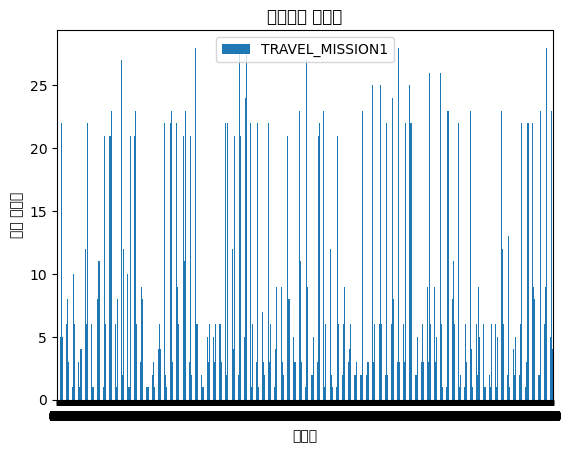

In [47]:
# 시각화
plt.figure(figsize=(25, 6))
total_data.plot(kind='bar', x="AGE_GRP_x", y="TRAVEL_MISSION1")
#plt.ylim(20,35)
plt.title('연령층별 지출액')
plt.xlabel('연령층')
plt.ylabel('평균 지출액')
plt.xticks(rotation=0)  # X축 라벨의 회전 각도
plt.show()